In [13]:
import sys
sys.path.append("../")
import os
import glob
import time
import numpy as np
import nibabel as nb
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import SimpleITK as sitk
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass

from tensorflow.keras.optimizers import Adam
from options.test_options import TestOptions
from models import deep_strain_model
from utils import myocardial_strain
from scipy.ndimage import gaussian_filter
import DeepStrain.functions_collection as ff

In [2]:
main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data/'

## Define Model 

To avoid using the command line scripts, here we create an `options` class to load the network directly. All we have to do is to specify the model path, etc. **For your part, download the ACDC dataset and change the path.**

In [8]:
class Options():
    
    def __init__(self):
        
        self.datadir = os.path.join(main_path,'data/ACDC')
        self.isTrain = False
        self.volume_shape = (128,128,16,1) # in network the input shape is [None, 128, 128, 16,2]
        self.pretrained_models_netS  = os.path.join(main_path,'models/trained/carson_Jan2021.h5')
        self.pretrained_models_netME = os.path.join(main_path,'models/trained/carmen_Jan2021.h5')
        
opt = Options()

model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

Vshape in network: , (None, 128, 128, 16, 2)
in network, we use 3D


2023-10-11 23:11:34.826077: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-10-11 23:11:34.826864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-10-11 23:11:34.944344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-11 23:11:34.946055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.44GiB deviceMemoryBandwidth: 1.41TiB/s
2023-10-11 23:11:34.946086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-10-11 23:11:34.947701: I tensorflow/stream_executor/platform/defau

## Global End-Systolic Strain

the segmentation is done manually

1 8


original shape:  (192, 192, 12)
original pixel dim is:  (1.458333, 1.458333, 10.246944)
labels:  [0. 2. 3.]
after concat, shape: , (192, 192, 12, 2)
after resample, shape:  (224, 224, 16, 2) (224, 224, 16, 2)
after crop, shape:  (128, 128, 16, 2) (128, 128, 16, 2)  Labels:  [0. 2. 3.]
before input into the model, the shape:  (1, 128, 128, 16) (1, 128, 128, 16)


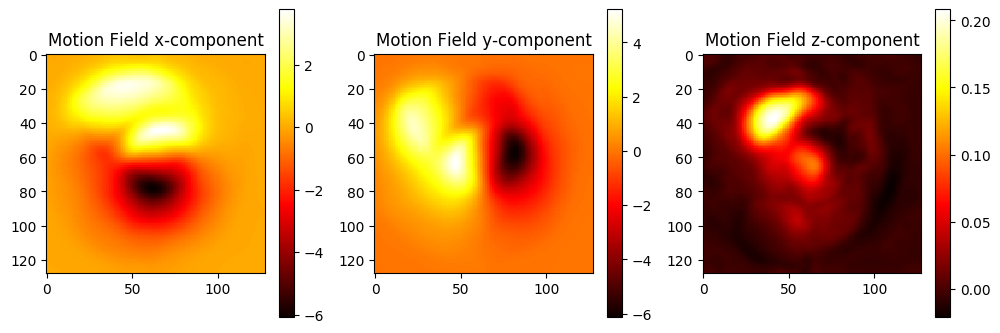

Radial strain:  20.52752287346383
Circumferential strain:  -13.019503183838014
strain image:  (128, 128, 16)


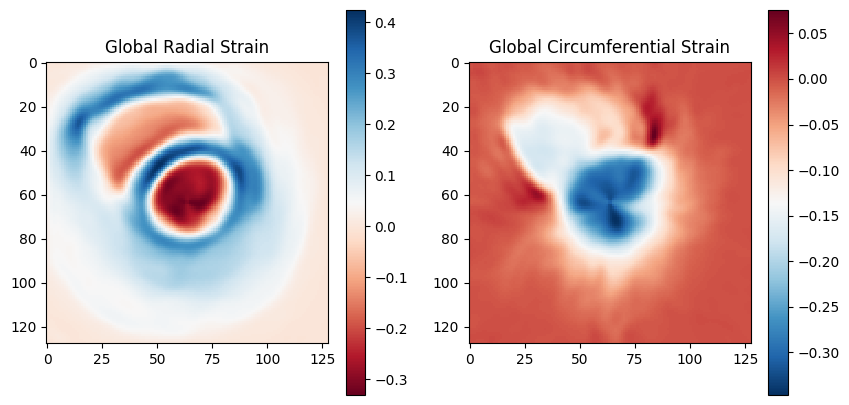

In [44]:
patient_id = 'ID_0483'
# first: get the ED and ES frame
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_notes.xlsx' ))
patient_id_num = ff.ID_00XX_to_XX(patient_id)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES'].values[0].astype(int)
print(ED,ES)

# second: load img and seg
patient_img_folder = os.path.join(data_path, 'nii_img', patient_id)
patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ED) + '.nii.gz'))
V_nifti_ES = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ES) + '.nii.gz'))
M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))
M_nifti_ES = nb.load(os.path.join(patient_seg_folder, 'SAX_ES_seg.nii.gz'))

# third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
M_ED[M_ED==1] = 3
M_nifti_ED = nb.Nifti1Image(M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)
M_ES = np.round(M_nifti_ES.get_fdata()).astype(int)
M_ES[M_ES==1] = 3
M_nifti_ES = nb.Nifti1Image(M_ES, affine=M_nifti_ES.affine, header=M_nifti_ES.header)

print('original shape: ',V_nifti_ED.get_fdata().shape)
print('original pixel dim is: ', V_nifti_ED.header.get_zooms())
print('labels: ', np.unique(M_nifti_ED.get_fdata()))

# fourth: prepare input
V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_ES))
M_nifti = nb.funcs.concat_images((M_nifti_ED, M_nifti_ES))
print('after concat, shape: ,', V_nifti.shape)

# data was trained with:
#  in-plane resolution of 1.25 mm x 1.25 mm
#  number of slices = 16
#  variable slice thickness since we specify number of slices
V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)
print('after resample, shape: ', V_nifti.shape, M_nifti.shape)

# calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2) # RV = 1, Myocardium = 2, LV = 3
V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)
print('after crop, shape: ', V.shape, M.shape, ' Labels: ', np.unique(M))

# 
V = ff.normalize_image(V)
nx, ny, nz, nt = V.shape
V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
V_t =  V[:,:,:,1:]

V_0 = np.transpose(V_0, (3,0,1,2))
V_t = np.transpose(V_t, (3,0,1,2))
print('before input into the model, the shape: ', V_0.shape, V_t.shape)

# fifth: predict motion vector
y_t = netME([V_0, V_t]).numpy()

# smooth the motion fields. Note that these motion fields can be used to warp points individually, or could be 
# used to deform an endocardial contour. 
y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

plt.figure(figsize=(12,4))
plt.subplot(131); plt.imshow(y_t[0,:,:,8,0], cmap='hot'); plt.title('Motion Field x-component'); plt.colorbar()
plt.subplot(132); plt.imshow(y_t[0,:,:,8,1], cmap='hot'); plt.title('Motion Field y-component'); plt.colorbar()
plt.subplot(133); plt.imshow(y_t[0,:,:,8,2], cmap='hot'); plt.title('Motion Field z-component'); plt.colorbar()
plt.show()

# last: calculate strain 
mask_end_diastole = M[..., 0]
    
strain = myocardial_strain.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
strain.calculate_strain(lv_label=2)

print('Radial strain: ', 100*strain.Err[strain.mask_rot==2].mean())
print('Circumferential strain: ', 100*strain.Ecc[strain.mask_rot==2].mean())
print('strain image: ', strain.Err.shape)

plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(strain.Err[:,:,8], cmap='RdBu'); plt.title('Global Radial Strain'); plt.colorbar()
plt.subplot(122); plt.imshow(strain.Ecc[:,:,8], cmap='RdBu_r'); plt.title('Global Circumferential Strain'); plt.colorbar()
plt.show() 


These results are identical to the ones reported in the manuscript. 

## Global Strain in All Subjects 

Now we would like to replicate the plots for strain across all time frames and across all subjects. In this case we don't have the ground-truh segmentations for the entire 4D dataset, therefore we will use carson to generate the masks. 

#### Segmentation 4D

In [53]:
class Options():
    
    def __init__(self):
        
        self.datadir = os.path.join(main_path,'data/ACDC')
        self.isTrain = False
        self.image_shape = (128,128,1) # 2D
        self.nlabels = 4
        self.pretrained_models_netS  = os.path.join(main_path,'models/trained/carson_Jan2021.h5')
        self.pretrained_models_netME = os.path.join(main_path,'models/trained/carmen_Jan2021.h5')
        
opt = Options()

model = deep_strain_model.DeepStrain(Adam, opt=opt)
netS  = model.get_netS()

In [35]:
from data import base_dataset
def get_mask(V):  # by trained netS
    nx, ny, nz, nt = V.shape
    
    M = np.zeros((nx,ny,nz,nt))
    v = V.transpose((2,3,0,1)).reshape((-1,nx,ny)) # (nz*nt,nx,ny)
    v = normalize(v)
    m = netS(v[:,nx//2-64:nx//2+64,ny//2-64:ny//2+64,None])
    M[nx//2-64:nx//2+64,ny//2-64:ny//2+64] += np.argmax(m, -1).transpose((1,2,0)).reshape((128,128,nz,nt))
    
    return M

subject 1 / 100
(216, 256, 10, 30)
(270, 320, 10, 30)
(270, 320, 10, 30)
0 5
in segmentation map m shape:  (50, 128, 128, 4)
5 10
in segmentation map m shape:  (50, 128, 128, 4)
10 15
in segmentation map m shape:  (50, 128, 128, 4)
15 20
in segmentation map m shape:  (50, 128, 128, 4)
20 25
in segmentation map m shape:  (50, 128, 128, 4)
25 30
in segmentation map m shape:  (50, 128, 128, 4)
(270, 320, 10, 30)
(256, 256, 10, 30) (256, 256, 10, 30)
in segmentation map m shape:  (300, 128, 128, 4)
(128, 128, 10, 30)
(216, 256, 10, 30)


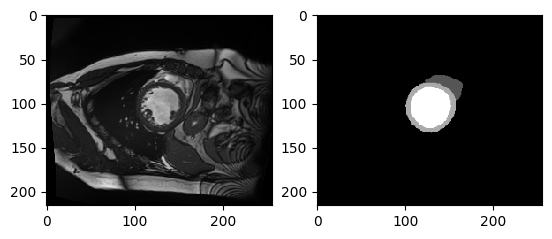

total time: 10.718405485153198


In [34]:
start = time.time()
for j, id in enumerate(range(1, 2)):
    print('subject %d / %d'%(j+1, 100))
    patientid = 'patient%.3d'%(id)
    patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
    info = pd.read_csv(os.path.join(patient_folder, 'info.cfg'), sep=':', header=None, index_col=False).T
    info.columns = info.iloc[0]
    info = info[1:]
    
    # notice that in this case the number of slices is set to none, therefore the resolution is kept
    # along the slice dimension.
    V_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
    print(V_nifti.get_fdata().shape)
    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=None)
    print(V_nifti_resampled.shape)
    
    # here we normalize per image, not volume
    V = V_nifti_resampled.get_fdata()
    V = normalize(V, axis=(0,1))
    print(V.shape)
    
    # In this case we don't yet have a segmentation we can use to crop the image. 
    # In most cases we can simply center crop (see `get_mask` function): 
    # M = get_mask(V)
    
    # However, in some instances the image could end up outside the FOV. While this is unlikely, please inspect 
    # your data.
    
    if False:
        # ONLY IF YOU KNOW YOUR IMAGE IS ROUGHLY NEAR CENTER 
        M_nifti_resampled = nib.Nifti1Image(M, affine=V_nifti_resampled.affine)
        # resample back to original resolution
        M_nifti = base_dataset.resample_nifti_inv(nifti_original=M_nifti_resampled, 
                                                  zooms=M_nifti_resampled.header.get_zooms()[:3], 
                                                  order=0, mode='nearest')
        
    else:
        # We could use VCN to center the heart, but an alternative approach is to use V as an approximate segmentation
        # to center the image. This of course means that we need to do the inverse opereation if we want to recover 
        # the image as a nifti. 

        # get approximate segmentation (in most cases this is enough)
        # get a time frame every 5 frames
        M = np.zeros(V.shape)
        for tf in range(0, V.shape[-1]//5 + 1):
            start_tf = tf*5
            if start_tf == V.shape[-1]:
                break
            end_tf = start_tf+5
            if end_tf > V.shape[-1]:
                end_tf = V.shape[-1]
            else:
                end_tf = start_tf+5
            print(start_tf, end_tf)
            V_partial = V[:,:,:, start_tf:end_tf]
            M_partial = get_mask(V_partial) 
            M[:,:,:, start_tf:end_tf] = M_partial           
#         M = get_mask(V)
        print(M.shape)

#         # now we calculate center of mass using the first frame as reference as before.
        center_resampled = center_of_mass(M[:,:,:,0]==2)
        V = base_dataset.roll_and_pad_256x256_to_center(x=V, center=center_resampled)
        M = base_dataset.roll_and_pad_256x256_to_center(x=M, center=center_resampled)
        center_resampled_256x256 = center_of_mass(M==3)
        print(V.shape, M.shape)

        # we save all this info to invert the segmentation bask to its original location/resolution
        nifti_info = {'affine'           : V_nifti.affine,
                      'affine_resampled' : V_nifti_resampled.affine,
                      'zooms'            : V_nifti.header.get_zooms(),
                      'zooms_resampled'  : V_nifti_resampled.header.get_zooms(),
                      'shape'            : V_nifti.shape,
                      'shape_resampled'  : V_nifti_resampled.shape,
                      'center_resampled' : center_resampled,
                      'center_resampled_256x256' : center_resampled_256x256} 

        M = get_mask(V)[128-64:128+64,128-64:128+64]
        print(M.shape)
        M_nifti = base_dataset.convert_back_to_nifti(M, nifti_info, inv_256x256=True, order=1, mode='nearest')
        print(M_nifti.get_fdata().shape)

        if j == 0:
            plt.subplot(121); plt.imshow(V_nifti.get_fdata()[:,:,5,0], cmap='gray')
            plt.subplot(122); plt.imshow(M_nifti.get_fdata()[:,:,5,0], cmap='gray')
            plt.show()

        # easy. Let's save the results now. 
        M_nifti.to_filename(os.path.join(patient_folder, patientid+'_4d_pred.nii.gz'))

end = time.time()
print('total time:', end - start)    

Let's plot an example. Change `id` to change subjects: 

In [44]:
id = 1
# save the result
patientid = 'patient%.3d'%(id)
patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
save_folder = os.path.join(patient_folder, '4d_per_frame')
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

V_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
# save each volumn along the last dimension
for i in range(0,V_nifti.get_fdata().shape[-1]):
    a = V_nifti.get_fdata()[:,:,:,i]
    a = nib.Nifti1Image(np.flip(a,axis = 1), affine=V_nifti.affine)
    nib.save(a, os.path.join(save_folder, patientid+'_frame%.2d.nii.gz'%(i)))

    
M_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d_pred.nii.gz'))
# save each volumn along the last dimension
for i in range(0,M_nifti.get_fdata().shape[-1]):
    a = M_nifti.get_fdata()[:,:,:,i]
    a = nib.Nifti1Image(np.flip(a,axis = 1), affine=M_nifti.affine)
    nib.save(a, os.path.join(save_folder, patientid+'_frame%.2d_pred.nii.gz'%(i)))

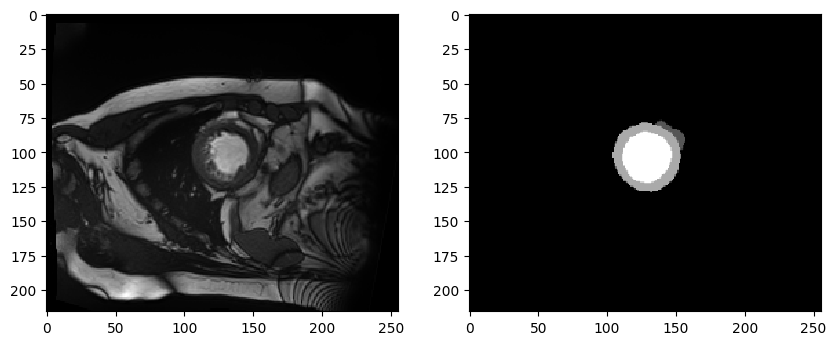

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(V_nifti.get_fdata()[:,:,7,6], cmap='gray')
plt.subplot(122)
plt.imshow(M_nifti.get_fdata()[:,:,7,6], cmap='gray')

Text(0, 0.5, 'Volume (mL)')

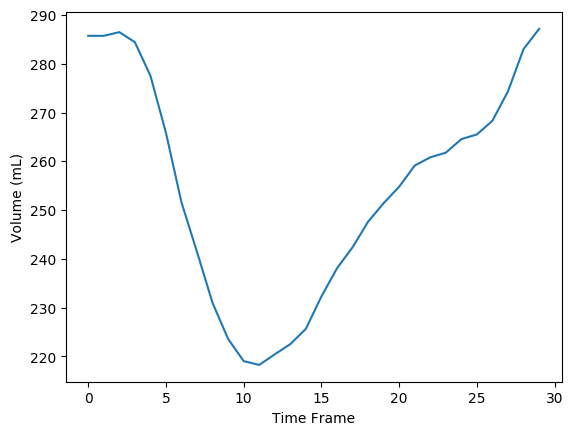

In [45]:
plt.plot((M_nifti.get_fdata()==3).sum(axis=(0,1,2))*np.prod(M_nifti.header.get_zooms()[:3])/1000)
plt.xlabel('Time Frame')
plt.ylabel('Volume (mL)')

#### Motion Estimation

Now that we have the 4D segmentations we can calculate strain: 

In [57]:
df = {'SubjectID':[], 'RadialStain':[], 'CircumferentialStrain':[], 'TimeFrame':[], 'Group':[]}

start = time.time()
for j, id in enumerate(range(1, 2)):
    print('subject %d / %d'%(j+1, 100))
    patientid = 'patient%.3d'%(id)
    patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
    info = pd.read_csv(os.path.join(patient_folder, 'info.cfg'), sep=':', header=None, index_col=False).T
    info.columns = info.iloc[0]
    info = info[1:]
    
    group = info.Group.item().strip(' ')
    
    V_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
    M_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d_pred.nii.gz'))
    print('shape: ', V_nifti.shape, M_nifti.shape)

    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
    M_nifti_resampled = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)


    center = center_of_mass(M_nifti_resampled.get_fdata()[:,:,:,0]==2)
    V = _roll2center_crop(x=V_nifti_resampled.get_fdata(), center=center)
    M = _roll2center_crop(x=M_nifti_resampled.get_fdata(), center=center)
    print('after resample and crop: ', V.shape, M.shape)
    
    V = normalize(V, axis=(0,1,2))
    
    V = V.transpose((3,0,1,2))
    M = M.transpose((3,0,1,2))
    
    V_0 = np.repeat(V[:1], len(V)-1, axis=0)[...,None]
    V_t = V[1:][...,None]
    print('before input, the shape: ', V_0.shape, V_t.shape)
    
    y_t = netME([V_0, V_t]).numpy()
    y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))
    print('motion shape: ', y_t.shape)

    mask_end_diastole = M[0]

    for time_frame in range(len(y_t)):

        strain = myocardial_strain.MyocardialStrain(mask=mask_end_diastole, flow=y_t[time_frame,:,:,:,:])
        strain.calculate_strain(lv_label=2)

        df['SubjectID']             += [id]
        df['RadialStain']           += [100*strain.Err[strain.mask_rot==2].mean()]   
        df['CircumferentialStrain'] += [100*strain.Ecc[strain.mask_rot==2].mean()]
        df['TimeFrame']             += [time_frame]
        df['Group']                 += [group]
    
    
df = pd.DataFrame(df)
print(df)

subject 1 / 100
shape:  (216, 256, 10, 30) (216, 256, 10, 30)


after resample and crop:  (128, 128, 16, 30) (128, 128, 16, 30)
before input, the shape:  (29, 128, 128, 16, 1) (29, 128, 128, 16, 1)
motion shape:  (29, 128, 128, 16, 3)
    SubjectID  RadialStain  CircumferentialStrain  TimeFrame Group
0           1    -0.162543              -0.068752          0   DCM
1           1    -1.269727              -1.024866          1   DCM
2           1    -1.606462              -2.140671          2   DCM
3           1    -0.612247              -2.977338          3   DCM
4           1     1.158512              -3.978353          4   DCM
5           1     3.029975              -4.909955          5   DCM
6           1     4.756115              -5.709644          6   DCM
7           1     6.342717              -6.377964          7   DCM
8           1     7.619605              -6.888348          8   DCM
9           1     8.582341              -7.153746          9   DCM
10          1     9.154124              -7.201612         10   DCM
11          1     9.13617

#### Comparison 

The figure below shows our published figure. 

In [90]:
from IPython.display import Image
Image(url= "https://www.frontiersin.org/files/Articles/730316/fcvm-08-730316-HTML-r1/image_m/fcvm-08-730316-g007.jpg")

And these are the results based on this repo: 

<AxesSubplot:xlabel='TimeFrame', ylabel='RadialStain'>

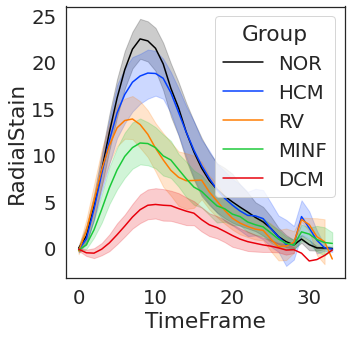

In [104]:
groups = ['NOR','HCM','RV','MINF','DCM']

current_palette = sns.color_palette()
current_palette = [(0,0,0)] + current_palette
sns.set(style='white', font_scale=1.8, palette="bright")

plt.figure(figsize=(5,5))
sns.lineplot(x='TimeFrame', y='RadialStain', hue='Group', data=df, palette=current_palette[:5], hue_order=groups)

### WHY THE DIFFERENCES? 

The images are not identical. In this notebook we are not taking into account the temporal resolution of the datasets. This can be extracted from the DICOMs. In fact, the temporal resolution is required to evaluate strain rate. We will address this in later notebooks. 